In [1]:
import pandas as pd

## Data preparation

In [2]:
# data source: https://surfdrive.surf.nl/files/index.php/s/CZWfWQp3VKGKa8m
df = pd.read_csv('data_with_ports.csv.gz', sep='|', compression='gzip')

C:\Users\Hsin\.conda\envs\venvCyber\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,17,19,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# parse string to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%dT%H:%M:%S+09:00')
df['stop_time'] = pd.to_datetime(df['stop_time'], format='%Y-%m-%dT%H:%M:%S+09:00')

In [4]:
# remove reserved ips
reserved_ips = [
    "0.",       # software
    "10.",      # private network
    "100.",     # private network
    "169.254.", # subnet
    "172.",     # private network
    "192."      # private network
]

df = df[~(df.org.isna() & df.target_ip.str.startswith(tuple(reserved_ips)))]

In [5]:
# fix NaNs in `regions` data for victims that reside in United States and Canada
df.loc[df.raw_country.str.contains("united states|canada", case=False), "region"] = "NA" # NA = North America

# fix comma in string
df.raw_country = df.raw_country.str.replace("<comma>", ",")

# fix `cc` and `region` missing values
df.loc[df.raw_country == "Tonga", "cc"] = "TO"; df.loc[df.raw_country == "Tonga", "region"] = "AP"
df.loc[df.raw_country == "Namibia", "cc"] = "NA"; df.loc[df.raw_country == "Namibia", "region"] = "AF"
df.loc[df.raw_country == "San Marino", "cc"] = "SM"; df.loc[df.raw_country == "San Marino", "region"] = "EU"
df.loc[df.raw_country == "Europe", "region"] = "EU"
df.loc[df.raw_country == "Asia/Pacific Region", "region"] = "AP"

# fix for "France, Metropolitan"
df.loc[df.raw_country.str.contains("france", case=False), "raw_country"] = "France"
df.loc[df.raw_country == "France", "cc"] = "FR"; df.loc[df.raw_country == "France", "region"] = "EU"

In [6]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5719250 entries, 0 to 5721431
Data columns (total 35 columns):
target_ip                 5719250 non-null object
date                      5719250 non-null datetime64[ns]
sensor_id                 5719250 non-null object
service                   5719250 non-null object
start_time                5719250 non-null datetime64[ns]
stop_time                 5719250 non-null datetime64[ns]
duration                  5719250 non-null float64
packets                   5719250 non-null int64
raw_country               5719250 non-null object
raw_as                    5719250 non-null object
raw_hostname              5719248 non-null object
udp_port_list             5719250 non-null object
pyasn_as                  5712272 non-null float64
pyasn_as_bgp_size         5502309 non-null float64
cc                        5695077 non-null object
region                    5703844 non-null object
is_oecd                   5693982 non-null float64
as_type   

In [7]:
from random import randint

df.iloc[randint(0, len(df))]

target_ip                                                   195.154.112.171
date                                                    2014-12-16 00:00:00
sensor_id                                                         sensor007
service                                                                ssdp
start_time                                              2014-12-16 15:53:16
stop_time                                               2014-12-16 16:13:06
duration                                                               1190
packets                                                                 238
raw_country                                                          France
raw_as                                                AS12876 ONLINE S.A.S.
raw_hostname                            195-154-112-171.rev.poneytelecom.eu
udp_port_list                                                        [9987]
pyasn_as                                                              12876
pyasn_as_bgp

In [8]:
# victim org         = org
# size of victims    = org_ipsize_seen
# type of victim     = caida_type
# country victim     = raw_country
# network hygiene    = count_attacks_2014
# dependent variable = count_attacks

orgs = (df.groupby(by=["org", "org_ipsize_seen", "caida_type", "raw_country", "region", "year"])
          .size().unstack().add_prefix("count_attack_")
          .fillna(0))

orgs.reset_index(inplace=True)
orgs.columns = orgs.columns.tolist()

orgs["count_attack"] = orgs.filter(regex="^count_attack").sum(axis=1)
orgs["count_attack_norm"] = orgs.count_attack / orgs.org_ipsize_seen

orgs.raw_country = orgs.raw_country.apply(lambda s: s.replace("<comma>", ","))

# remove companies that received just 1 attack, as we assume the first attack was only a trial
orgs = orgs[orgs.count_attack > 1]

#### ITU ICT index

In [9]:
# https://tcdata360.worldbank.org/indicators/h2e1ddd20
itu_index = pd.read_csv("ITU-ICT-index.csv")

# fix naming mismatch for "Slovakia" and "Korea, Republic of"
itu_index.loc[itu_index.Country.str.contains("Korea"), "Country"] = "Korea, Republic of"
itu_index.loc[itu_index.Country.str.contains("Slovak"), "Country"] = "Slovakia"

orgs = pd.merge(orgs, itu_index, how="left", 
                left_on="raw_country", right_on="Country").drop(columns=["Country"])

#### Export data

In [10]:
orgs.to_csv("orgs.csv")

In [11]:
orgs

,org,org_ipsize_seen,caida_type,raw_country,region,count_attack_2014,count_attack_2015,count_attack,count_attack_norm,ITU-ICT
0,"#3BEo, Sangkat Beoun Prolit, Khan 7Makara, Phn...",38.0,Transit/Access,Cambodia,AP,0.0,9.0,9.0,0.236842,2.8
1,& Aguiar Ltda Me,10.0,Transit/Access,Brazil,LC,1.0,2.0,3.0,0.300000,5.7
2,& Dantas Ltda,40.0,Transit/Access,Brazil,LC,3.0,0.0,3.0,0.075000,5.7
3,& Matera Ltda,9.0,Transit/Access,Brazil,LC,0.0,6.0,6.0,0.666667,5.7
4,& Rapchan Ltda. - Me,37.0,Transit/Access,Brazil,LC,5.0,15.0,20.0,0.540541,5.7
...,...,...,...,...,...,...,...,...,...,...
21582,zicom Next Spolka Z Ograniczona Odpowiedzialno...,7.0,Enterpise,Poland,EE,45.0,54.0,99.0,14.142857,6.6
21583,zorislav_eremita,19.0,Transit/Access,United States,NA,0.0,3.0,3.0,0.157895,8.1
21584,zukashishifu_,20.0,Transit/Access,United States,NA,0.0,10.0,10.0,0.500000,8.1
21585,zukuchiri_,21.0,Transit/Access,United States,NA,0.0,14.0,14.0,0.666667,8.1


## Visualisation

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
orgs = pd.read_csv("orgs.csv")
orgs.region = orgs.region.fillna("NA") # fix `NA` = "North America"

In [14]:
orgs.head()

,Unnamed: 0,org,org_ipsize_seen,caida_type,raw_country,region,count_attack_2014,count_attack_2015,count_attack,count_attack_norm,ITU-ICT
0,0,"#3BEo, Sangkat Beoun Prolit, Khan 7Makara, Phn...",38.0,Transit/Access,Cambodia,AP,0.0,9.0,9.0,0.236842,2.8
1,1,& Aguiar Ltda Me,10.0,Transit/Access,Brazil,LC,1.0,2.0,3.0,0.300000,5.7
2,2,& Dantas Ltda,40.0,Transit/Access,Brazil,LC,3.0,0.0,3.0,0.075000,5.7
3,3,& Matera Ltda,9.0,Transit/Access,Brazil,LC,0.0,6.0,6.0,0.666667,5.7
4,4,& Rapchan Ltda. - Me,37.0,Transit/Access,Brazil,LC,5.0,15.0,20.0,0.540541,5.7


#### Per IP size

Most companies have their `org_ipsize_seen` < threshold with few "outliers" having very large `org_ipsize_seen`. This is illustrated with the very narrow whisker ends and far-away flier points in the boxplot.

In [15]:
THRESHOLD = 5e4

count    2.158700e+04
mean     5.540855e+03
std      5.801418e+04
min      1.000000e+00
25%      2.300000e+01
50%      1.150000e+02
75%      6.455000e+02
max      1.730303e+06
Name: org_ipsize_seen, dtype: float64

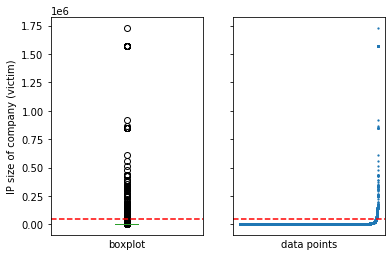

In [16]:
fig, ax = plt.subplots(1, 2, sharey=True)

org_ipsize_seen_sorted = orgs.org_ipsize_seen.sort_values().reset_index(drop=True).reset_index()

orgs.org_ipsize_seen.plot.box(ax=ax[0])
org_ipsize_seen_sorted.plot.scatter(x="index", y="org_ipsize_seen", ax=ax[1], s=1.5)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].set_xticks([]), ax[1].set_xticks([])
ax[0].set_ylabel("IP size of company (victim)")
ax[0].set_xlabel("boxplot"), ax[1].set_xlabel("data points")

# draw a threshold
ax[0].axhline(y=THRESHOLD, color='r', linestyle="--")
ax[1].axhline(y=THRESHOLD, color='r', linestyle="--")

# print statistics
orgs.org_ipsize_seen.describe()

In [17]:
# the big hosting providers (`org_ipsize_seen` > THRESHOLD)
orgs.loc[orgs.org_ipsize_seen > THRESHOLD]

,Unnamed: 0,org,org_ipsize_seen,caida_type,raw_country,region,count_attack_2014,count_attack_2015,count_attack,count_attack_norm,ITU-ICT
26,26,1&1 Internet,73813.0,Transit/Access,United States,NA,189.0,634.0,823.0,0.011150,8.1
27,27,1&1 Internet,73813.0,Transit/Access,Germany,WE,0.0,4.0,4.0,0.000054,8.1
28,28,1&1 Internet AG,181901.0,Transit/Access,Germany,WE,539.0,2135.0,2674.0,0.014700,8.1
29,29,1&1 Internet AG,181901.0,Transit/Access,France,EU,3.0,3.0,6.0,0.000033,8.0
30,30,1&1 Internet AG,181901.0,Transit/Access,Spain,WE,1.0,3.0,4.0,0.000022,7.5
...,...,...,...,...,...,...,...,...,...,...,...
20967,20967,home.pl webhosting farm - static allocation,121203.0,Content,Poland,EE,49.0,170.0,219.0,0.001807,6.6
21196,21196,nLayer Communications,95875.0,Content,United States,NA,10.0,0.0,10.0,0.000104,8.1
21197,21197,nLayer Communications,95875.0,Transit/Access,United States,NA,105.0,235.0,340.0,0.003546,8.1
21205,21205,nazwa.pl webhosting servers,62481.0,Content,Poland,EE,15.0,65.0,80.0,0.001280,6.6


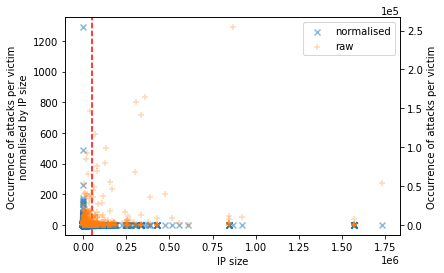

In [18]:
fig, ax1 = plt.subplots()
p1 = ax1.scatter(x=orgs.org_ipsize_seen, y=orgs.count_attack_norm, marker="x", alpha=.5)
ax1.set_ylabel("Occurrence of attacks per victim\nnormalised by IP size"), ax1.set_xlabel("IP size")
ax1.axvline(x=THRESHOLD, color='r', linestyle="--")

ax2 = ax1.twinx()
p2 = ax2.scatter(x=orgs.org_ipsize_seen, y=orgs.count_attack, marker="+", color="C1", alpha=.3)
ax2.set_ylabel("Occurrence of attacks per victim")

ax2.legend([p1, p2], ["normalised", "raw"], loc=0)

plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
fig.savefig("images/attack-by-ipsize.png")

#### Per Country

In [19]:
# color the boxplots per region
regions = orgs.region.unique()
raw_countries = orgs.sort_values(by=["region", "raw_country"]).raw_country.unique()
colors = {regions[i] : sns.color_palette(n_colors=len(regions))[i] for i in range(len(regions))}

# repalce abbrs with fullname
regions_f = ["Western Europe",   # WE
             "North America",    # NA
             "Asian Pacific",    # AP
             "Eastern Europe",   # EE
             "Latin America",    # LC
             "Middle East",      # ME
             "Africa" ]          # AF

In [20]:
# import matplotlib.patches as mpatches

# # plot per country
# fig, ax = plt.subplots(len(raw_countries), figsize=(8,12), sharex=True)

# for i in range(len(raw_countries)):
#     region = orgs.region[orgs.raw_country == raw_countries[i]].values[0]
#     sns.boxplot(x="count_attack", y="raw_country", orient="h", color=colors[region],
#                 data=orgs.sort_values(by=["region", "raw_country"]).loc[orgs.raw_country == raw_countries[i]], ax=ax[i])  
    
#     # formatting axis
#     ax[i].set_ylabel("")
#     ax[i].set_xlabel("")
#     ax[i].spines["top"].set_visible(False)
#     ax[i].spines["bottom"].set_visible(False)
#     ax[i].tick_params(axis='both', which='both', length=0)
    
# ax[i].set(xscale="log")
# ax[0].spines["top"].set_visible(True)
# ax[i].spines["bottom"].set_visible(True)
# ax[i].set_xlabel("Occurrence of attack against victims")
# plt.legend(handles=[mpatches.Patch(color=colors[regions[i]], label=regions_f[i]) 
#                     for i in range(len(regions))], bbox_to_anchor=(1., 1.2*len(raw_countries)),
#           title="Region")

# fig.savefig("images/attack-by-country.png")